In [ ]:
// https://github.com/bentrevett/pytorch-image-classification/blob/master/4_vgg.ipynb

In [ ]:
import os
import torch
import numpy as np
import torch.nn as nn
from torchvision import datasets ,models,transforms
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torchsummary import summary
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
ls /gdrive/MyDrive/IVP_project/

alexnet/     Brain_MRI_NET_2020.pdf  brain_tumor_dataset/  Mid_eval.gslides
archive.zip  brainMRnet/             GoogLeNet/


In [ ]:
data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
train_data = datasets.ImageFolder('/gdrive/MyDrive/IVP_project/brain_tumor_dataset', transform = data_transforms) 
generator=torch.Generator().manual_seed(0)
train_dataset, val_dataset = torch.utils.data.random_split(train_data, [round(train_data.__len__()*0.7),round(train_data.__len__()*0.3)],generator=generator)

In [ ]:
batch_size = 32
dataloaders = {
    'train': torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
    'val': torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
}

dataset_sizes = {'train':len(train_dataset), 'val':len(val_dataset)}
class_names = ['no','yes']
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_acc':[], 'val_acc':[],'train_loss':[],'val_loss':[]}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            history[phase + '_loss'].append(epoch_loss)
            history[phase + '_acc'].append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
model_ft = models.resnet18(pretrained=True)
set_parameter_requires_grad(model_ft, True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
input_size = 224

In [ ]:
# model_ft = models.vgg16(pretrained=True)
# set_parameter_requires_grad(model_ft, True)
# num_ftrs = model_ft.classifier[6].in_features
# model_ft.classifier[6] = nn.Linear(num_ftrs,2)
# input_size = 224

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
summary(model_ft.cuda(), (3,224,224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:

model_ft, history = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=100)

Epoch 0/99
----------
train Loss: 0.7601 Acc: 0.4802
val Loss: 0.7150 Acc: 0.5395

Epoch 1/99
----------
train Loss: 0.6857 Acc: 0.5819
val Loss: 0.6569 Acc: 0.6316

Epoch 2/99
----------
train Loss: 0.6643 Acc: 0.6271
val Loss: 0.6310 Acc: 0.6316

Epoch 3/99
----------
train Loss: 0.6023 Acc: 0.6893
val Loss: 0.5706 Acc: 0.6842

Epoch 4/99
----------
train Loss: 0.5540 Acc: 0.7232
val Loss: 0.5293 Acc: 0.7105

Epoch 5/99
----------
train Loss: 0.5189 Acc: 0.7627
val Loss: 0.5538 Acc: 0.7368

Epoch 6/99
----------
train Loss: 0.5122 Acc: 0.7684
val Loss: 0.4688 Acc: 0.7895

Epoch 7/99
----------
train Loss: 0.4979 Acc: 0.7853
val Loss: 0.4629 Acc: 0.7500

Epoch 8/99
----------
train Loss: 0.4640 Acc: 0.7740
val Loss: 0.4991 Acc: 0.7632

Epoch 9/99
----------
train Loss: 0.4894 Acc: 0.8136
val Loss: 0.4719 Acc: 0.7895

Epoch 10/99
----------
train Loss: 0.4913 Acc: 0.7740
val Loss: 0.4687 Acc: 0.7500

Epoch 11/99
----------
train Loss: 0.4629 Acc: 0.8023
val Loss: 0.5124 Acc: 0.7368

Ep

In [ ]:
history['train_acc']
new_list = [x+5 for x in history['train_acc']]

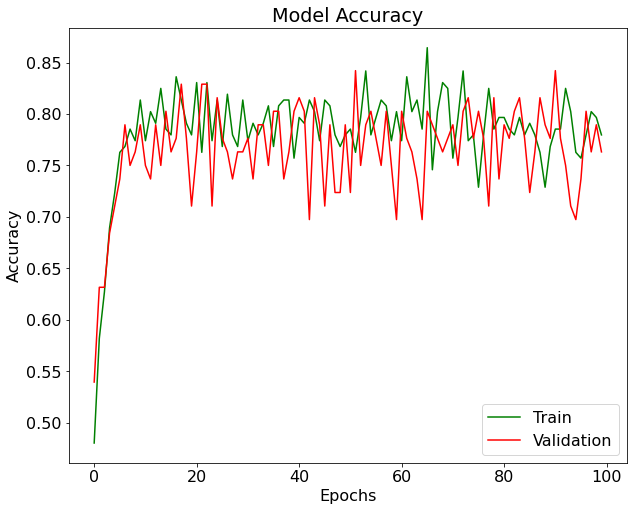

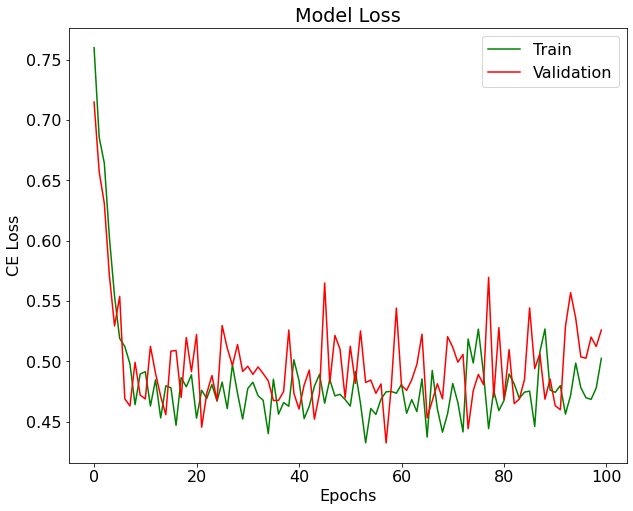

In [ ]:
num_epochs = range(len(history['train_loss']))
plt.rcParams['font.size'] = 16

plt.figure(figsize = (10,8))
plt.plot(num_epochs,history['train_acc'],'g')
plt.plot(num_epochs,history['val_acc'],'r')
plt.legend(['Train', 'Validation'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
# plt.savefig(root + 'GoogLeNet_Accuracy.png',tight_layout = True)
plt.show()
plt.figure(figsize = (10,8))
plt.plot(num_epochs,history['train_loss'],'g')
plt.plot(num_epochs,history['val_loss'],'r')
plt.legend(['Train', 'Validation'])
plt.xlabel("Epochs")
plt.ylabel("CE Loss")
plt.title("Model Loss")
# plt.savefig(root + 'GoogLeNet_Loss.png',tight_layout = True)
plt.show()